In [61]:
# importing the needed packages to explore the data
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download ('wordnet')
import stopwordsiso

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("punkt")
from nltk.stem import PorterStemmer

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tolu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tolu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tolu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
# read in the bbc data
bbc_data = pd.read_csv('bbc-news-data.csv', sep='\t')
# Removing duplicated articles from the database
bbc_data.drop_duplicates(subset=['category','title', 'content'],keep='last',inplace=True)
# remove columns from the dataframe that are not needed
bbc_data['text'] = bbc_data['title']+ '' + bbc_data['content']
bbc_data = bbc_data[['category', 'text']]
# dataset description
bbc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2127 non-null   object
 1   text      2127 non-null   object
dtypes: object(2)
memory usage: 49.9+ KB


In [63]:
# displaying the unique categories of articles present in the data
print(bbc_data['category'].unique())
# factorizing the categories
label_encoder = preprocessing.LabelEncoder()
bbc_data['cat_id']= label_encoder.fit_transform(bbc_data['category'])
# creating a temporary dataframe 'df' to determine the distribution of the categories
df = bbc_data['category'].value_counts().to_frame().reset_index()
df = df.rename(columns={'index':'Category', 'category':'Article Count'})

# determining how varied the category distribution is from balanced distribution
df['Actual Ratio'] = df['Article Count']/df['Article Count'].sum()

# plotting the distribution of the categories
fig = px.bar(df, x='Category',y = 'Article Count',color='Category', text='Article Count', title='Article Category Count')
fig.update_layout(yaxis_title='Article Count', xaxis_title = 'Category')
fig.show()
fig.write_image("plots\\barplot.png")
fig = px.pie(df,names='Category', values='Actual Ratio',title='Article Category Distribution')
fig.show()
fig.write_image("plots\\pieplot.png")
# Determining the difference between actual ratio distribution and expected
df['Expected Ratio'] = 1/len(bbc_data['category'].unique())
df['Difference'] = abs(df['Actual Ratio']-df['Expected Ratio'])
df[['Category','Expected Ratio','Actual Ratio','Difference']]

['business' 'entertainment' 'politics' 'sport' 'tech']


,Category,Expected Ratio,Actual Ratio,Difference
0,sport,0.2,0.237424,0.037424
1,business,0.2,0.236483,0.036483
2,politics,0.2,0.189469,0.010531
3,entertainment,0.2,0.173484,0.026516
4,tech,0.2,0.163141,0.036859


From the above we can see that sports and business articles make up most of the dataset; with tech having the smallest article count. However, the overall difference between the categories is relatively small. The dataset is fairly balanced, with the largest difference from the expected ratio being 4%.

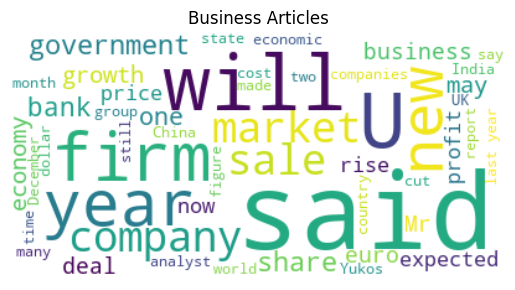

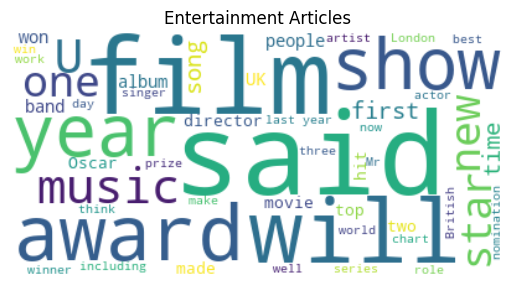

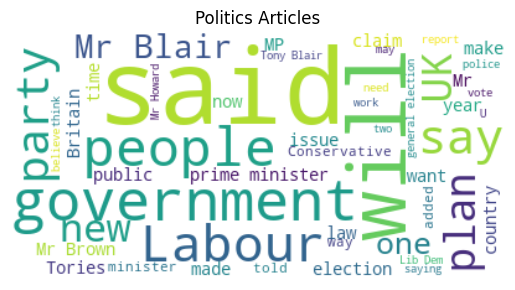

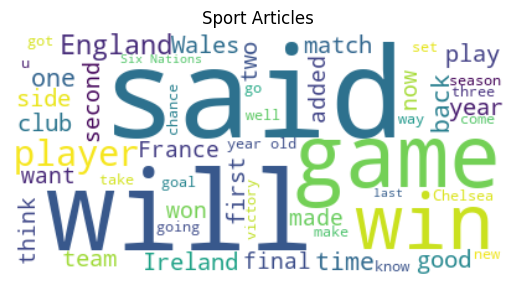

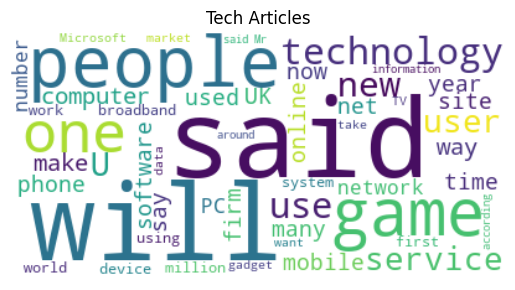

In [64]:
for cat in bbc_data['category'].unique():
    df = bbc_data.loc[bbc_data["category"]==cat]["text"].str.cat(sep=' ')



    # create word cloud for each category based on the article content
    wordcloud = WordCloud(stopwords = STOPWORDS,background_color = "white",max_words = 50).generate(df)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{cat.title()} Articles')
    plt.show()
    

In [65]:
nltk_stops = set(nltk.corpus.stopwords.words('english'))
print(len(nltk_stops))
stops = nltk_stops
git_stop = stopwordsiso.stopwords("en")
stops.update(git_stop)
print(len(stops))

179
1304


preprocess steps:
    remove symbols and numbers
    lower case everything but the 'US' >> 'united states'
    remove stop words >> had to look for a more comprehensive list of stop words
    lemmatize the token
    and lower case again to get 'US' >> 'us' 

In [66]:
def clean_text(text):
    text = re.sub("[^a-zA-Z]"," ",text)
    text = text.split(' ')
    text = [w if w in ['US', 'DS','OS','PS'] else w.lower() for w in text]
    return  ' '.join(text)

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stops]
    return ' '.join(no_stopword_text)


def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(w) for w in text.split()]
    return ' '.join(lem)


def stemming(text):
    stemmer = PorterStemmer()
    lem = [stemmer.stem(w) for w in text.split()]
    return ' '.join(lem)
bbc_data['clean_text'] = bbc_data['text'].apply(clean_text)
bbc_data['clean_text'] = bbc_data['clean_text'].apply(remove_stopwords)
bbc_data['clean_text_lem'] = bbc_data['clean_text'].apply(lemmatization)
bbc_data['clean_text_stem'] = bbc_data['clean_text'].apply(stemming)
bbc_data['clean_text_lem'] = bbc_data['clean_text_lem'].str.lower()
bbc_data['clean_text_stem']=bbc_data['clean_text_stem'].str.lower()

In [67]:
bbc_data.shape

(2127, 6)

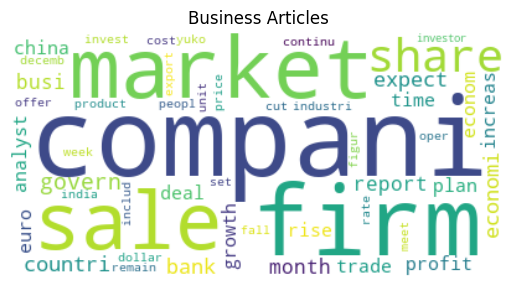

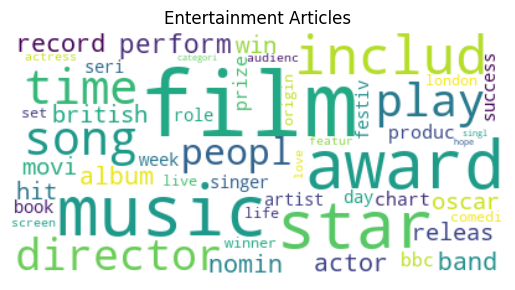

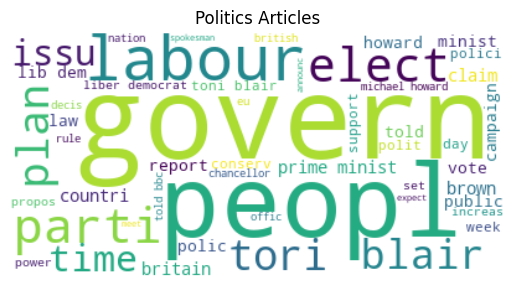

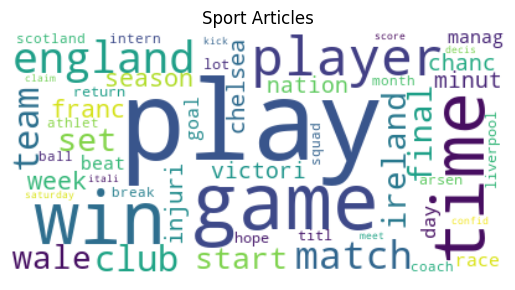

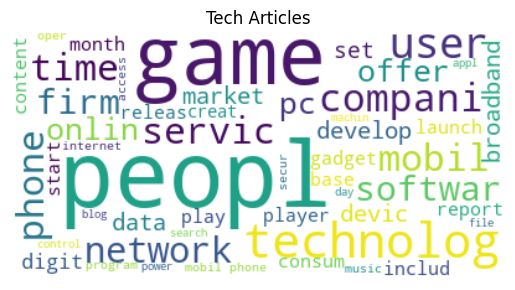

In [68]:
for cat in bbc_data['category'].unique():
    df = bbc_data.loc[bbc_data["category"]==cat]["clean_text_stem"].str.cat(sep=' ')
    # create word cloud for each category based on the article content
    wordcloud = WordCloud(stopwords =stops,background_color = "white",max_words = 50).generate(df)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{cat.title()} Articles')
    plt.show()

    freq_dist = nltk.FreqDist(df.split())

    freq_dist = pd.DataFrame({'word':list(freq_dist.keys()),'count':list(freq_dist.values())})

    fig = px.bar(freq_dist.nlargest(20,'count').sort_values('count'),y='word',x='count',
        title=f'Frequency of Words in {cat.title()}',color = 'count')
    fig.update_layout(yaxis=dict(dtick=1))
    fig.show()

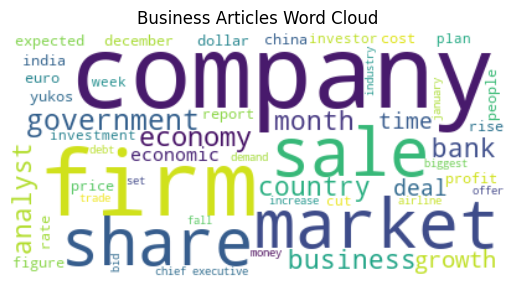

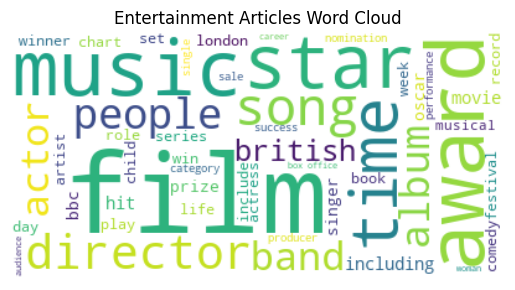

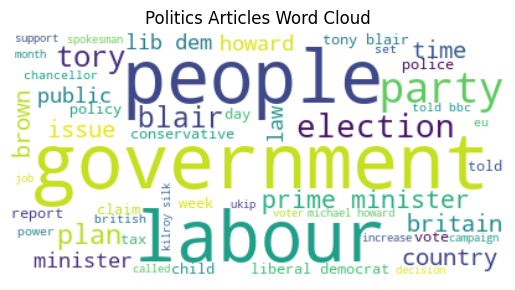

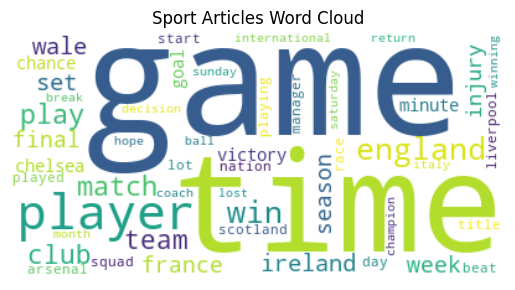

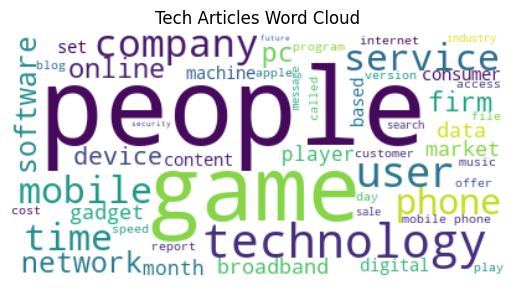

In [69]:
for cat in bbc_data['category'].unique():
    df = bbc_data.loc[bbc_data["category"]==cat]["clean_text_lem"].str.cat(sep=' ')



    # create word cloud for each category based on the article content
    wordcloud = WordCloud(stopwords =stops,background_color = "white",max_words = 50).generate(df)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{cat.title()} Articles Word Cloud')
    plt.savefig(f"plots\\{cat}_wordcloud.png")
    plt.show()
    
    freq_dist = nltk.FreqDist(df.split())

    freq_dist = pd.DataFrame({'word':list(freq_dist.keys()),'count':list(freq_dist.values())})

    fig = px.bar(freq_dist.nlargest(20,'count').sort_values('count'),y='word',x='count',
        title=f'Word Frequencies {cat.title()} Articles',color = 'count')
    fig.update_layout(yaxis=dict(dtick=1))
    fig.write_image(f"plots\\{cat}_freq.png")
    fig.show()

In [70]:
temp = bbc_data["clean_text_lem"].str.cat(sep=' ')
temp = set(temp.split())
temp_l = list(temp)
temp_l.sort()

In [71]:
clean_words = bbc_data["clean_text_lem"].str.cat(sep=' ').split()
words = bbc_data["text"].str.cat(sep=' ').split()

In [72]:
print(len(set(clean_words)), len(set(words)))

24136 65553


In [73]:
24136 /65553

0.36819062438027245

In [74]:
# ds = bbc_data['text'].loc[bbc_data['text'].str.contains('O')].tolist()

In [75]:
temp2 = bbc_data['text'].apply(clean_text).str.cat(sep=' ')
temp2 = set(temp2.split())
temp_l2 = list(temp2)
temp_l2.sort()

In [76]:
temp_l2.index('o')

17121

In [77]:
# import json

# # convert the list to a JSON string
# json_string = json.dumps(ds)
# with open('output1.json', 'w') as f:
#     # write the list as JSON to the file
#     json.dump(ds, f)

In [80]:
vectorizer_bow = CountVectorizer()
bow = vectorizer_bow.fit_transform(bbc_data['clean_text_lem'])
vectorizer_tfidf = TfidfVectorizer()
tfidf = vectorizer_tfidf.fit_transform(bbc_data['clean_text_lem'])
idf = vectorizer_tfidf.idf_
bow_tfidf = np.multiply(bow.toarray(), idf)
stop_time = time.time()


In [81]:
Y = bbc_data[['category', 'cat_id']]
bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer_bow.get_feature_names_out())
# bow_df[['bbc_category_names','cat_id']] = bbc_data[['category','cat_id']]
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer_bow.get_feature_names_out())
# tfidf_df[['bbc_category_names','cat_id']] = bbc_data[['category','cat_id']]
bow_tfidf_df = pd.DataFrame(bow_tfidf, columns=vectorizer_bow.get_feature_names_out())
# bow_tfidf_df[['bbc_category_names','cat_id']] = bbc_data[['category','cat_id']]

In [82]:
max_tfidf = bow_tfidf_df.max().sort_values(ascending=False)
df = pd.DataFrame(max_tfidf.head(20)).reset_index()
df.rename(columns={'index':'word', 0:'tfidf_score'}, inplace=True)
fig = px.bar(df,x ='tfidf_score', y='word',
title="Top 20 Highest TF-IDF Score Words",color='tfidf_score')
fig.update_yaxes(autorange="reversed")
fig.update_layout(xaxis_title='TF-IDF score', yaxis_title = 'word')
fig.update_layout(yaxis=dict(dtick=1))
fig.write_image(f"plots\\tfidf.png")
fig.show()


In [83]:
computational_time = {}
reduced_data = {}

In [84]:
size = [int(round(.25*bow.shape[1],0)), int(round(.10*bow.shape[1],0)),int(round(.05*bow.shape[1],0)),int(round(.01*bow.shape[1],0)),int(round(.001*bow.shape[1],0))]

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32, stratify='y')

# Convert the text data to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [85]:
np.random.seed(32)
for i in size:
    start_time = time.time()
    vectorizer_tfidf = TfidfVectorizer(max_features=i)
    tfidf = vectorizer_tfidf.fit_transform(bbc_data['clean_text_lem'])
    stop_time = time.time()
    idf = vectorizer_tfidf.idf_
    
    computational_time[f'tf-idf_{i}'] = stop_time - start_time 
    reduced_data[f'tf-idf_{i}'] = tfidf
    reduced_data[f'idf_{i}'] = idf

In [87]:
bow_tfidf_df.shape

(2127, 24134)

In [88]:
from sklearn.decomposition import TruncatedSVD
np.random.seed(32)
for i in size:
    print(i)
    start_time = time.time()
    lsa_obj = TruncatedSVD(n_components=i, n_iter=50, random_state=32)
    tfidf_lsa_data = lsa_obj.fit_transform(bow_tfidf_df)
    stop_time = time.time()
    computational_time[f'lsa_{i}'] = stop_time - start_time 
    reduced_data[f'lsa_{i}'] = tfidf_lsa_data
    reduced_data[f'lsa_sigma_{i}'] = lsa_obj.singular_values_
    reduced_data[f'las_v_{i}']= lsa_obj.components_.T





6034
2413
1207
241
24


In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
np.random.seed(32)
for i in size:
    print(i)
    start_time = time.time()
    lda = LinearDiscriminantAnalysis(n_components=i)
    lda.fit(bow_tfidf_df, Y.iloc[:,1])
    X_lda = lda.transform(bow_tfidf_df.iloc[:,:-2])
    stop_time = time.time()
    computational_time[f'lda_{i}'] = stop_time - start_time 
    reduced_data[f'lda_{i}'] = X_lda
    reduced_data[f'lda_sigma_{i}'] = lda.n_components
    reduced_data[f'lda_v_{i}']= lda.components_.T

6034


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

# Define the autoencoder architecture
input_layer = Input(shape=(1000,))
encoder = Dense(50, activation='relu')(input_layer)
decoder = Dense(1000, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_compressed = encoder_model.predict(X_train_tfidf)
X_test_compressed = encoder_model.predict(X_test_tfidf)

In [74]:
# sns.barplot(x=list(range(len(Sigma))), y = Sigma)
# term_topic_matrix = pd.DataFrame(data=lsa_term_topic, 
#                                  index = eda_train.columns, 
#                                  columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])

# data = term_topic_matrix[f'Latent_concept_1']
# data = data.sort_values(ascending=False)
# top_10 = data[:10]
# plt.title('Top terms along the axis of Latent concept 1')
# fig = sns.barplot(x= top_10.values, y=top_10.index)

TruncatedSVD(n_components=20, n_iter=100, random_state=42)

In [ ]:
from sklearn.svm import SVC

# Train an SVM on the compressed representation of the training data
clf = SVC()
clf.fit(X_train_compressed, y_train)

# Evaluate the accuracy on the compressed representation of the test data
accuracy = clf.score(X_test_compressed, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
import gensim
from gensim.models import LsiModel, LdaModel
from keras.models import Model
from keras.layers import Input, Dense

# Load the corpus and dictionary
corpus = gensim.corpora.MmCorpus('corpus.mm')
dictionary = gensim.corpora.Dictionary.load('dictionary.dict')

# Train LSA model and get similarity matrix
lsa_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=50)
similarity_matrix_lsa = gensim.similarities.MatrixSimilarity(lsa_model[corpus])

# Train LDA model and get similarity matrix
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=50)
similarity_matrix_lda = gensim.similarities.MatrixSimilarity(lda_model[corpus])

# Train autoencoder model and get encoded vectors
input_dim = len(dictionary)
encoding_dim = 50
input_layer = Input(shape=(input_dim,))
encoded_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoded_layer = Dense(input_dim, activation='sigmoid')(encoded_layer)
autoencoder_model = Model(input_layer, decoded_layer)
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_model.fit(corpus, corpus, epochs=50, batch_size=32)
encoder_model = Model(input_layer, encoded_layer)
encoded_vectors_autoencoder = encoder_model.predict(corpus)

# Calculate cosine similarity between pairs of words
word_pairs = [('apple', 'banana'), ('computer', 'mouse'), ('car', 'bus')]
for pair in word_pairs:
    word1, word2 = pair
    word1_idx = dictionary.token2id[word1]
    word2_idx = dictionary.token2id[word2]
    word1_lsa = lsa_model[corpus[word1_idx]]
    word2_lsa = lsa_model[corpus[word2_idx]]
    word1_lda = lda_model[corpus[word1_idx]]
    word2_lda = lda_model[corpus[word2_idx]]
    word1_autoencoder = encoded_vectors_autoencoder[word1_idx]
    word2_autoencoder = encoded_vectors_autoencoder[word2_idx]
    similarity_lsa = gensim.matutils.cossim(word1_lsa, word2_lsa)
    similarity_lda = gensim.matutils.cossim(word1_lda, word2_lda)
    similarity_autoencoder = gensim.matutils.cossim(word1_autoencoder, word2_autoencoder)
    print(f'Similarity between {word1} and {word2} using LSA: {similarity_lsa:.2f}')
    print(f'Similarity between {word1} and {word2} using LDA: {similarity_lda:.2f}')
    print(f'Similarity between {word1} and {word2} using autoencoder: {similarity_autoencoder:.2f}')


In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from keras.models import Model
from keras.layers import Input, Dense

# Load the data
data = np.loadtxt('data.txt')

# Train LSA model and calculate reconstruction error
lsa_model = TruncatedSVD(n_components=50)
data_lsa = lsa_model.fit_transform(data)
data_lsa_reconstructed = lsa_model.inverse_transform(data_lsa)
reconstruction_error_lsa = np.mean(np.square(data - data_lsa_reconstructed))

# Train LDA model and calculate reconstruction error
lda_model = LatentDirichletAllocation(n_components=50)
data_lda = lda_model.fit_transform(data)
data_lda_reconstructed = np.dot(data_lda, lda_model.components_)
reconstruction_error_lda = np.mean(np.square(data - data_lda_reconstructed))

# Train autoencoder model and calculate reconstruction error
input_dim = data.shape[1]
encoding_dim = 50
input_layer = Input(shape=(input_dim,))
encoded_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoded_layer = Dense(input_dim, activation='sigmoid')(encoded_layer)
autoencoder_model = Model(input_layer, decoded_layer)
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_model.fit(data, data, epochs=50, batch_size=32)
reconstruction_error_autoencoder = autoencoder_model.evaluate(data, data, verbose=0)

print(f'Reconstruction error for LSA: {reconstruction_error_lsa:.2f}')
print(f'Reconstruction error for LDA: {reconstruction_error_lda:.2f}')
print(f'Reconstruction error for autoencoder: {reconstruction_error_autoencoder:.2f}')


In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.models import Model
from keras.layers import Input, Dense

# Load the data
data = np.loadtxt('data.txt')

# Train LSA model and calculate reconstruction error
lsa_model = TruncatedSVD(n_components=50)
data_lsa = lsa_model.fit_transform(data)
data_lsa_reconstructed = lsa_model.inverse_transform(data_lsa)
reconstruction_error_lsa = np.mean(np.square(data - data_lsa_reconstructed))

# Train LDA model and calculate reconstruction error
lda_model = LinearDiscriminantAnalysis(n_components=50)
data_lda = lda_model.fit_transform(data, labels)
data_lda_reconstructed = np.dot(data_lda, lda_model.scalings_.T)
reconstruction_error_lda = np.mean(np.square(data - data_lda_reconstructed))

# Train autoencoder model and calculate reconstruction error
input_dim = data.shape[1]
encoding_dim = 50
input_layer = Input(shape=(input_dim,))
encoded_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoded_layer = Dense(input_dim, activation='sigmoid')(encoded_layer)
autoencoder_model = Model(input_layer, decoded_layer)
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_model.fit(data, data, epochs=50, batch_size=32)
reconstruction_error_autoencoder = autoencoder_model.evaluate(data, data, verbose=0)

print(f'Reconstruction error for LSA: {reconstruction_error_lsa:.2f}')
print(f'Reconstruction error for LDA: {reconstruction_error_lda:.2f}')
print(f'Reconstruction error for autoencoder: {reconstruction_error_autoencoder:.2f}')
